In [13]:
# read & manipulate data
import keras_tuner as kt
import pandas as pd 
import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# visualisations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# load the dataset
import os
import sys
sys.path.append("../scripts")

# misc
import random as rn
import warnings
import utils

# setting random seeds for libraries to ensure reproducibility
RANDOM_SEED = 420
TRAINING_SAMPLE = 15000
VALIDATE_SIZE = 0.2
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
model_path = '/Users/junxingli/Desktop/master_thesis/models/ann_sfs/' 
feat_path = '7_features'
tuner_path = os.path.join(model_path, feat_path)
file_path = os.path.join(model_path, 'results.pkl')

overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/ann-sfs/'
plots_path = figs_path + feat_path

df = pd.read_pickle(pkl_path)
df = df[df['Status'] == 'Stable']
features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()

X = df.drop(['Status', 'SRD', 'T5'], axis=1)
y = df[['Time', 'SRD']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standard scaling the data
scaler = StandardScaler()
cols = [col for col in X_train.columns if col != 'Time']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Need to reshape since the scaler expects a 2D array
y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

def update_dataframe(df, selected_features, training_error, test_error):
    """
    Update the DataFrame with a new row containing information about the selected features, training error, and test error.
    
    Parameters:
    selected_features (list): A list of selected features for this round.
    training_error (float): The training error for this round.
    test_error (float): The test error for this round.
    
    Returns:
    pandas.DataFrame: The updated DataFrame with the new row appended.
    """
    # Create a new row with 0s for all features
    features = df.columns.to_list()[:-2]
    new_row = {feature: 0 for feature in features}
    
    # Update the row based on the selected features for this round
    for feature in selected_features:
        new_row[feature] = 1
        
    # Add training and test error
    new_row['Training Error'] = training_error
    new_row['Test Error'] = test_error
    
    # Append the new row to the DataFrame
    df.loc[len(df.index)] = new_row
    return df

def get_metrics(model, scaler, X, y):
    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))
    rmse = mean_squared_error(y_inv['SRD'], y_pred.flatten(), squared=False)
    r2 = r2_score(y_inv['SRD'], y_pred.flatten())
    
    return rmse, r2

def tune_ANN(df, X_features, proj_path, update=False):
    X = df[X_features]
    y = df[['SRD']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2)
    
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    class MyHyperModel(kt.HyperModel):
        def build(self, hp): 
            hp_learning_rate = hp.Choice('learning_rate', 
                                        values=[1e-1, 1e-2])
                
            model = keras.Sequential()
            model.add(Input(shape=(input_dim,)))
            for i in range(hp.Int('num_layers', 0, 3)):
                model.add(Dense(units=hp.Int('units_' + str(i), 
                                            min_value=5, 
                                            max_value=60, 
                                            step=5),
                                activation='relu'))
            
            model.add(Dense(output_dim, activation='linear'))
            
            # Select optimizer    
            optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
            if optimizer == 'adam':
                model.compile(
                optimizer=keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'SGD':
                model.compile(
                optimizer=keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'rmsprop':
                model.compile(
                optimizer=keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            
            return model

        def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                batch_size=hp.Choice("batch_size", [32, 64, 128]),
                **kwargs,
            )
    
    # Standard scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
    y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))
    
    metric = 'val_mean_squared_error'
    tuner = kt.Hyperband(MyHyperModel(),
                         objective=metric,
                         max_epochs=200,
                         overwrite=False,
                         directory=tuner_path,
                         project_name=proj_path)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor=metric, 
                                                patience=10)

    tuner.search(X_train, y_train, epochs=200, 
                 validation_split=0.25, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    History = best_model.fit(X_train, 
                            y_train, 
                            epochs=200, 
                            callbacks=[tf.keras.callbacks.EarlyStopping(
                                        monitor='mean_squared_error', 
                                        patience=50)
                                        ],
                            validation_split=0)
    
    rmse_train, r2_train = get_metrics(best_model, scaler, X_train, y_train)
    rmse_test, r2_test = get_metrics(best_model, scaler, X_test, y_test)
    
    # Save the model architecture and hyperparameters as txt-file
    summary_dir = os.path.join(tuner_path, proj_path, '00summary')
    os.makedirs(summary_dir, exist_ok=True)
    filename = 'model_summary.txt'
    summary_path = os.path.join(summary_dir, filename)

    with open(summary_path, 'w') as f:
        txt = f"""Training error: {rmse_train}
        R2 score: {r2_train}
        -------------------------------------
        Test error: {rmse_test}
        R2 score: {r2_test}
        -------------------------------------
        Parameters: {X_features}
        """
        f.write(str(txt))
        best_model.summary(print_fn=lambda x: f.write(x + '\n'))
        
        if hasattr(best_hps, 'values'):
            for param, value in best_hps.values.items():
                f.write(f"{param}: {value}\n")
        else:
            f.write(str(best_hps))
            
    # Save the model feautures and errors to a DataFrame
    if update:
        if not os.path.exists(file_path):
            features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()
            sfs_df = pd.DataFrame(columns=features + ['Training Error', 'Test Error'])
            sfs_df.to_pickle(file_path)
        
        sfs_df = pd.read_pickle(file_path)    
        sfs_df = update_dataframe(sfs_df, X_features, rmse_train, rmse_test)
        sfs_df.to_pickle(file_path)
    return best_model

In [ ]:
def search_features(df, optimal_features, features, proj_path, update=False):
    for i, feature in enumerate(features, start=1):
        # Skip features that are already identified as optimal
        if feature in optimal_features:
            continue

        proj_path = f'var{i}'
        tune_ANN(df, optimal_features + [feature], proj_path, update=True)

optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1']
search_features(df, optimal_features, features, 'sfs', update=True)

In [ ]:
def find_optimal_features(df, num_features, method='train'):
    """
    Identifies columns with a value of 1 in the row with the minimum training or test error,
    after filtering rows based on the sum of their feature values being equal to num_features.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - num_features (int): The number of features that must sum to 1 to consider a row.
    - method (str): The error type to minimize ('train' or 'test').
    
    Returns:
    - list: A list of optimal feature column names.
    """

    df_filtered = df.drop(['Training Error', 'Test Error'], axis=1)
    df_filtered['Sum'] = df_filtered.sum(axis=1)
    df_features = df_filtered[df_filtered['Sum'] == num_features]
    
    # Check if there are any rows meeting the criteria
    if df_features.empty:
        raise ValueError("No rows with the specified number of features found.")
    
    # Find indexes of rows with minimum error within the filtered DataFrame
    idx_train = df_features.join(df['Training Error'])['Training Error'].idxmin()
    idx_test = df_features.join(df['Test Error'])['Test Error'].idxmin()
    if idx_train != idx_test:
        warnings.warn("Best training and best test are not the same!")
    
    # Select the row based on the specified method
    if method == 'train':
        optimal_row = df.loc[idx_train]
    elif method == 'test':
        optimal_row = df.loc[idx_test]
    else:
        raise ValueError("Method must be either 'train' or 'test'")
    
    print(f"Optimal row: {optimal_row}")
    
    # Identify columns with a value of 1 in the optimal row
    optimal_features = optimal_row.index[optimal_row.eq(1)].tolist()
    
    return optimal_features

sfs_df = pd.read_pickle(file_path)
print(find_optimal_features(sfs_df, 7, 'train'))
print(find_optimal_features(sfs_df, 7, 'test'))
#sfs_df

In [11]:
model.predict(X_train[optimal_features+new_feature])

299/299 [==============================] - 0s 339us/step


array([[-655.35004],
       [-654.13556],
       [-651.17725],
       ...,
       [-660.29767],
       [-659.8205 ],
       [-656.12573]], dtype=float32)

Reloading Tuner from /Users/junxingli/Desktop/master_thesis/models/ann_sfs/7_features/var3/tuner0.json
Epoch 1/200
299/299 [==============================] - 0s 575us/step - loss: 0.2591 - mean_squared_error: 0.2591
Epoch 2/200
299/299 [==============================] - 0s 974us/step - loss: 0.2511 - mean_squared_error: 0.2511
Epoch 3/200
299/299 [==============================] - 0s 837us/step - loss: 0.2417 - mean_squared_error: 0.2417
Epoch 4/200
299/299 [==============================] - 0s 646us/step - loss: 0.2395 - mean_squared_error: 0.2395
Epoch 5/200
299/299 [==============================] - 0s 633us/step - loss: 0.2311 - mean_squared_error: 0.2311
Epoch 6/200
299/299 [==============================] - 0s 635us/step - loss: 0.2308 - mean_squared_error: 0.2308
Epoch 7/200
299/299 [==============================] - 0s 607us/step - loss: 0.2358 - mean_squared_error: 0.2358
Epoch 8/200
299/299 [==============================] - 0s 572us/step - loss: 0.2273 - mean_squared_error: 

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File Parity_plot_ANN7.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/Parity_plot_ANN7.pdf.


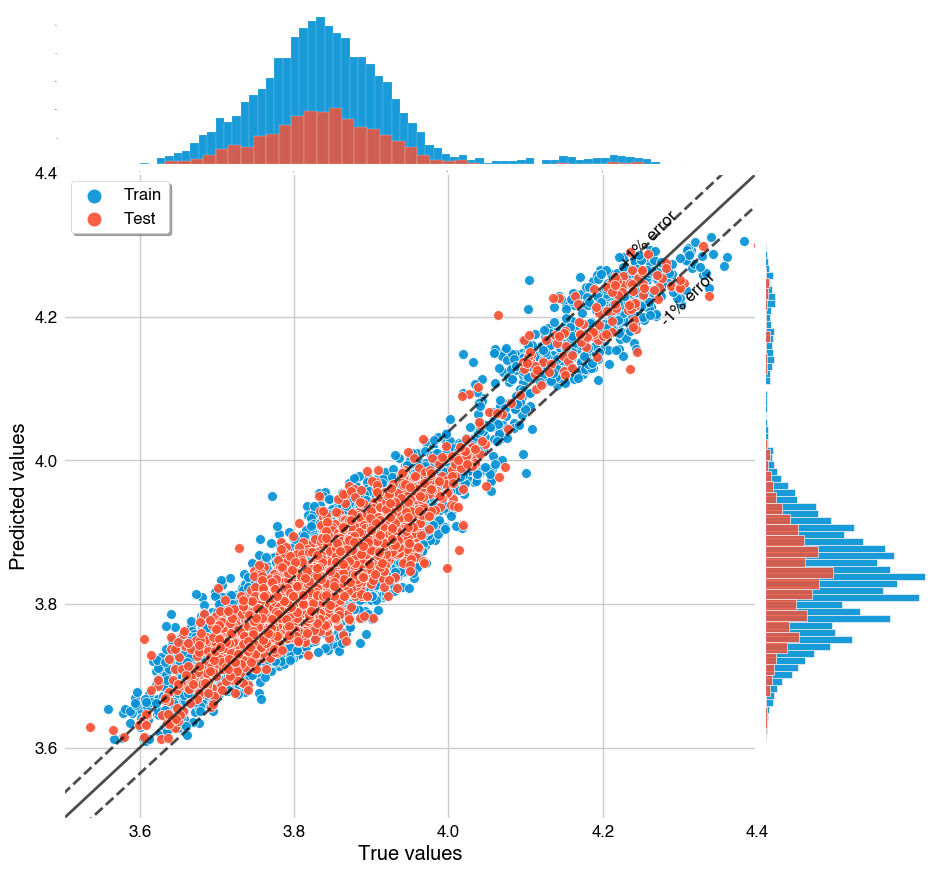

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File Residuals_plot_ANN7.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/Residuals_plot_ANN7.pdf.


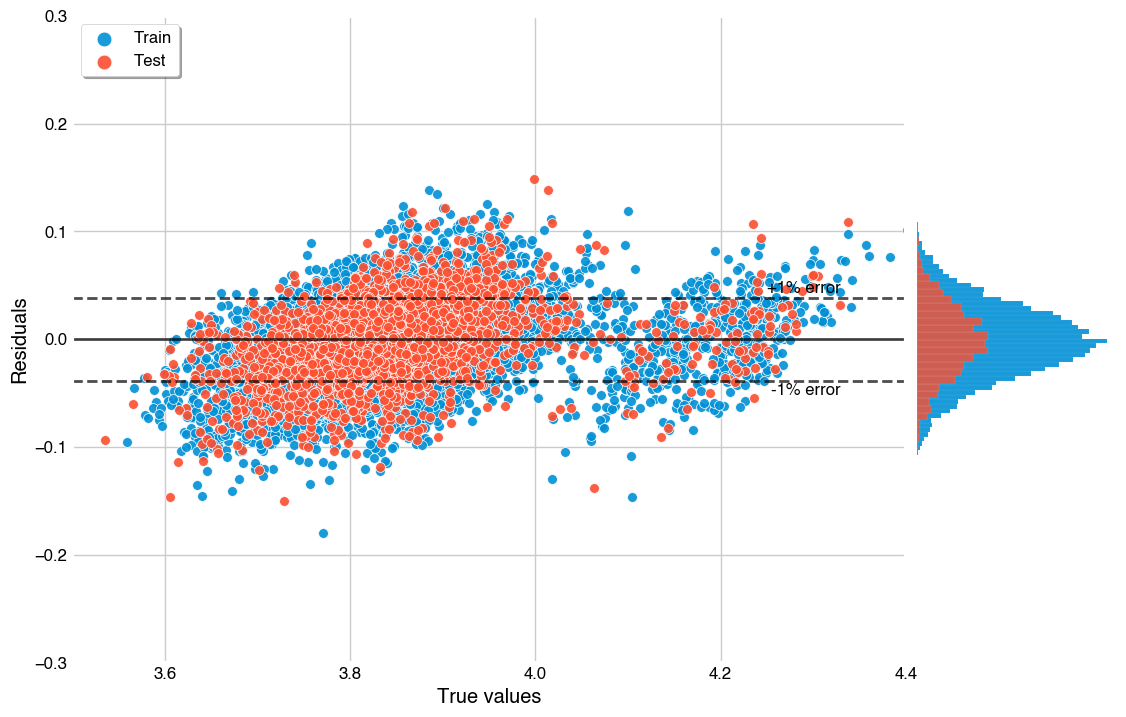

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File KDE_plot_ANN7.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/KDE_plot_ANN7.pdf.


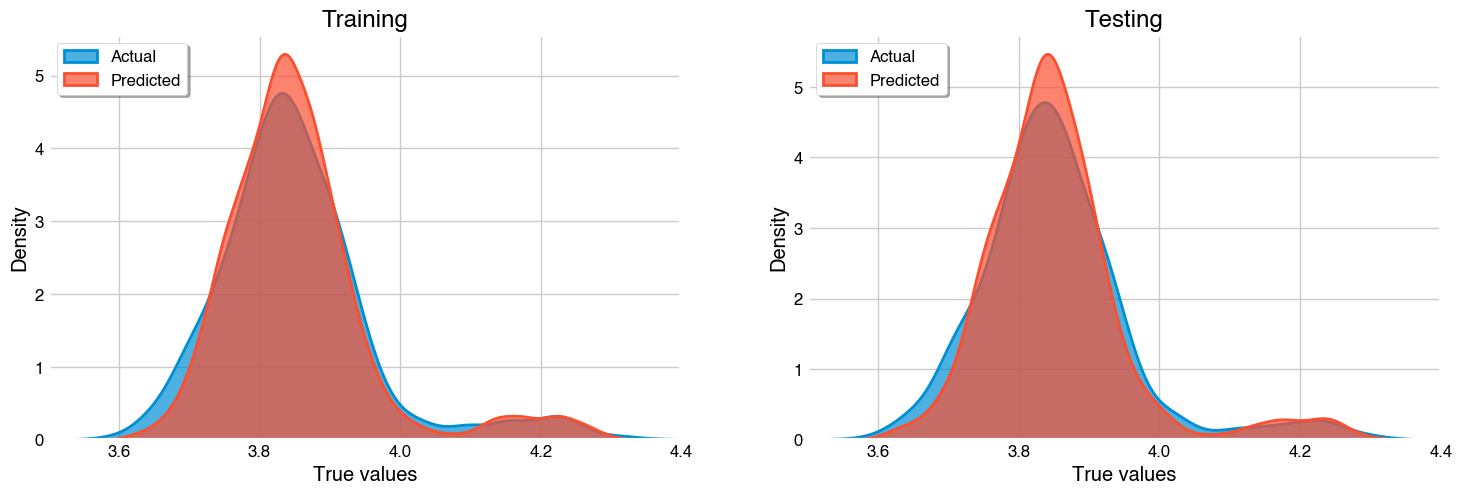

In [16]:
optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1']
new_feature = ['T1']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == new_feature[0]:
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train, r2_train = utils.generate_prediction_df(model, scaler, X_train[optimal_features+new_feature+['Time']],y_train)
df_test, rmse_test, r2_test = utils.generate_prediction_df(model, scaler, X_test[optimal_features+new_feature+['Time']],y_test)

utils.make_evaluation_plots(df_train,
                            df_test,
                            "ANN7",
                            plots_path, 
                            overwrite=True, 
                            limit=[3.5, 4.4], 
                            error_line=0.01, 
                            res_limit=[-0.3, 0.3], 
                            mean=df['SRD'].mean())